### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Алламе Ормиз 
##### Группа:  НФИбд-01-21

## Москва 2024
***

### Вариант № 20

# 1.Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, и валидационную и тестовую выборки. Если при дальнейшей работе с данными возникнет нехватка вычислительных ресурсов, то разрешение изображений можно уменьшить.

In [1]:
from sklearn.metrics import confusion_matrix
from matplotlib import rcParams
import random
from PIL import Image, ImageOps
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
name = 'stl10'

n = 60
m = 90

ds = tfds.load(name, split=['train[:80%]', 'train[80%:100%]', 'test'])

df_train = tfds.as_dataframe(ds[0])[['image', 'label']]
df_test = tfds.as_dataframe(ds[1])[['image', 'label']]
df_val = tfds.as_dataframe(ds[2])[['image', 'label']]

# 2. Оставьте в наборе изображения, указанных в индивидуальном задании, и визуализируйте несколько изображений

In [3]:
values_to_keep = [2,4,5,7,9]

In [4]:
def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)
    num_row = 2
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    for i in range(num_row * num_col):
        img = imgs[i] 
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
df_train1 = []
for i in df_train.values:
    if i[1] in values_to_keep:
        df_train1.append(i)
df_train = pd.DataFrame(df_train1)

df_test1 = []
for i in df_test.values:
    if i[1] in values_to_keep:
        df_test1.append(i)
df_test = pd.DataFrame(df_test1)

df_val1 = []
for i in df_val.values:
    if i[1] in values_to_keep:
        df_val1.append(i)
df_val = pd.DataFrame(df_val1)

train_labels = df_train[1].to_numpy(dtype=np.float32)
test_labels = df_test[1].to_numpy(dtype=np.float32)
val_labels = df_val[1].to_numpy(dtype=np.float32)

n_classes = len(set(train_labels))

train_labels = np.array([i % n_classes for i in range(len(train_labels))])
test_labels = np.array([i % n_classes for i in range(len(test_labels))])
val_labels = np.array([i % n_classes for i in range(len(val_labels))])

print(np.unique(train_labels))

train_images = np.zeros(shape=(df_train.shape[0], n, m, 3), dtype=np.float32)
test_images = np.zeros(shape=(df_test.shape[0], n, m, 3), dtype=np.float32)
val_images = np.zeros(shape=(df_val.shape[0], n, m, 3), dtype=np.float32)

for idx in range(train_labels.shape[0]):
    img = Image.fromarray(df_train.iloc[idx][0])
    img_resized = img.resize((n, m), Image.LANCZOS)
    img_array = np.array(img_resized)
    train_images[idx] = np.transpose(img_array, (1, 0, 2))

for idx in range(test_labels.shape[0]):
    img = Image.fromarray(df_test.iloc[idx][0])
    img_resized = img.resize((n, m), Image.LANCZOS)
    img_array = np.array(img_resized)
    test_images[idx] = np.transpose(img_array, (1, 0, 2))

for idx in range(val_labels.shape[0]):
    img = Image.fromarray(df_val.iloc[idx][0])
    img_resized = img.resize((n, m), Image.LANCZOS)
    img_array = np.array(img_resized)
    val_images[idx] = np.transpose(img_array, (1, 0, 2))

train_images /= 255.0
test_images /= 255.0
val_images /= 255.0

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=n_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=n_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=n_classes)

[0 1 2 3 4]


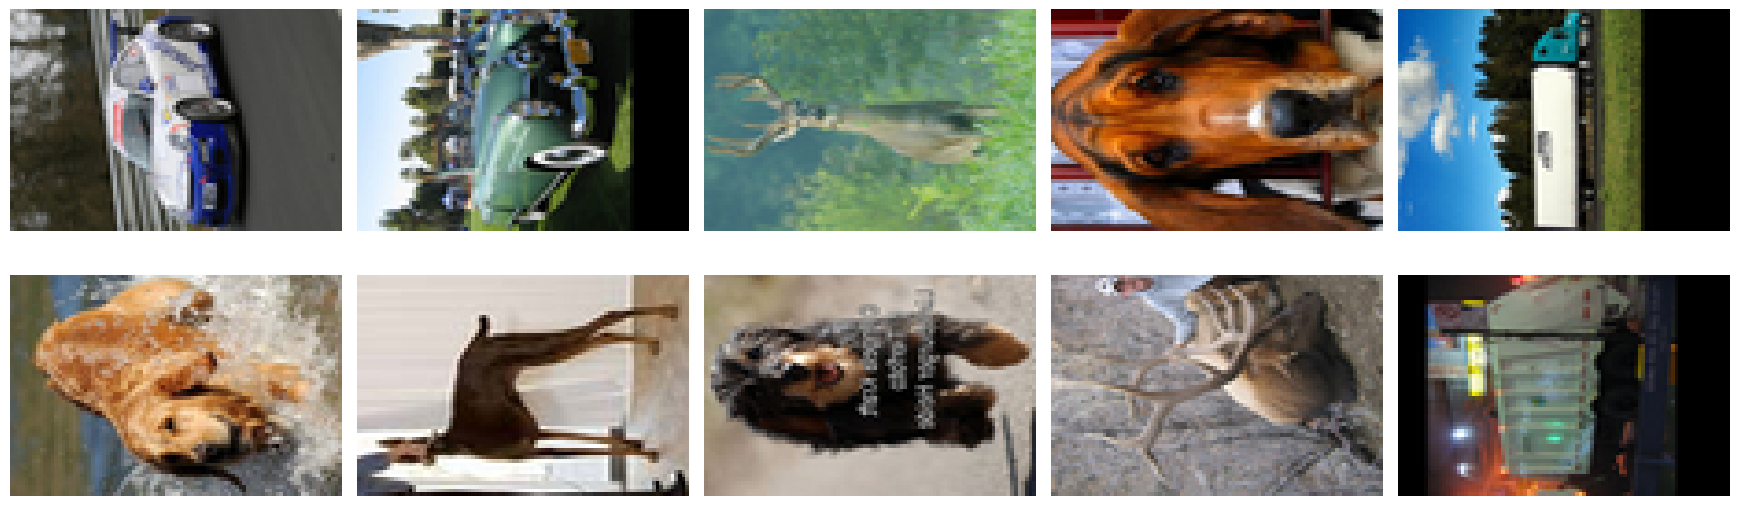

In [6]:
plot_random_sample(train_images)

# 3. Постройте нейронные сети MLP, CNN и RNN для задачи многоклассовой классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании), используя функцию потерь, указанную в индивидуальном задании. Подберите такие параметры обучения, как оптимизатор, начальная скорость обучения самостоятельно, обеспечивая обучение нейронных сетей. Останавливайте обучение нейронных сетей в случае роста потерь на валидационной выборке на нескольких эпохах обучения подряд. Для каждой нейронной сети выведите количество потребовавшихся эпох обучения. 

In [7]:
epoch = 100

In [8]:
train_labels_sparse = tf.argmax(train_labels, axis=1)
val_labels_sparse = tf.argmax(val_labels, axis=1)

In [9]:
train_labels_sparse = tf.argmax(train_labels, axis=1)
val_labels_sparse = tf.argmax(val_labels, axis=1)

inputs = tf.keras.Input(shape=(n, m, 3))
x = tf.keras.layers.Flatten()(inputs)

for i in range(6):
    if i % 2 == 0:
        x = tf.keras.layers.Dense(50, activation='selu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    else:
        x = tf.keras.layers.Dense(40, activation='selu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)

outputs = tf.keras.layers.Dense(len(values_to_keep), activation='softmax')(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_images,
    train_labels_sparse, 
    epochs=epoch,
    batch_size=128,
    validation_data=(val_images, val_labels_sparse), 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
16/16 [==============================] - 3s 50ms/step - loss: 5.4284 - accuracy: 0.1921 - val_loss: 4.9934 - val_accuracy: 0.2042
Epoch 2/100
16/16 [==============================] - 0s 26ms/step - loss: 4.9006 - accuracy: 0.2096 - val_loss: 4.8665 - val_accuracy: 0.1992
Epoch 3/100
16/16 [==============================] - 0s 27ms/step - loss: 4.8345 - accuracy: 0.1921 - val_loss: 4.7925 - val_accuracy: 0.2050
Epoch 4/100
16/16 [==============================] - 0s 25ms/step - loss: 4.7656 - accuracy: 0.2081 - val_loss: 4.7421 - val_accuracy: 0.2090
Epoch 5/100
16/16 [==============================] - 0s 26ms/step - loss: 4.7179 - accuracy: 0.2086 - val_loss: 4.7131 - val_accuracy: 0.2072
Epoch 6/100
16/16 [==============================] - 0s 25ms/step - loss: 4.6841 - accuracy: 0.2344 - val_loss: 4.6760 - val_accuracy: 0.1975
Epoch 7/100
16/16 [==============================] - 0s 26ms/step - loss: 4.6456 - accuracy: 0.2125 - val_loss: 4.6395 - val_accuracy: 0.1960
Epoch 

16/16 [==============================] - 0s 28ms/step - loss: 3.0651 - accuracy: 0.5032 - val_loss: 3.8919 - val_accuracy: 0.2048
Epoch 59/100
16/16 [==============================] - 0s 28ms/step - loss: 3.1174 - accuracy: 0.4589 - val_loss: 3.6552 - val_accuracy: 0.2062
Epoch 60/100
16/16 [==============================] - 0s 26ms/step - loss: 2.9428 - accuracy: 0.5739 - val_loss: 3.7628 - val_accuracy: 0.1925
Epoch 61/100
16/16 [==============================] - 0s 26ms/step - loss: 2.9110 - accuracy: 0.5650 - val_loss: 3.6974 - val_accuracy: 0.2055
Epoch 62/100
16/16 [==============================] - 0s 28ms/step - loss: 2.8769 - accuracy: 0.5913 - val_loss: 3.7821 - val_accuracy: 0.1982
Epoch 63/100
16/16 [==============================] - 0s 27ms/step - loss: 2.9806 - accuracy: 0.5212 - val_loss: 3.7842 - val_accuracy: 0.1980
Epoch 64/100
16/16 [==============================] - 0s 27ms/step - loss: 2.8574 - accuracy: 0.5854 - val_loss: 3.7649 - val_accuracy: 0.1925
Epoch 65/100

In [10]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same', input_shape=(n, m, 3)))
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same'))
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same'))
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(90, activation='selu'))
model_2.add(tf.keras.layers.Dropout(0.3))
model_2.add(tf.keras.layers.Dense(60, activation='selu'))
model_2.add(tf.keras.layers.Dropout(0.3))
model_2.add(tf.keras.layers.Dense(5, activation='softmax'))
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    metrics=['accuracy']
)
history_2 = model_2.fit(
    train_images,
    train_labels,
    epochs=epoch,
    batch_size=128,
    validation_data=(val_images, val_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/100
16/16 [==============================] - 6s 250ms/step - loss: 1.6483 - accuracy: 0.1996 - val_loss: 1.6100 - val_accuracy: 0.1947
Epoch 2/100
16/16 [==============================] - 4s 232ms/step - loss: 1.6094 - accuracy: 0.2106 - val_loss: 1.6101 - val_accuracy: 0.1937
Epoch 3/100
16/16 [==============================] - 4s 247ms/step - loss: 1.6056 - accuracy: 0.2305 - val_loss: 1.6100 - val_accuracy: 0.1877
Epoch 4/100
16/16 [==============================] - 3s 221ms/step - loss: 1.6025 - accuracy: 0.2364 - val_loss: 1.6115 - val_accuracy: 0.1905
Epoch 5/100
16/16 [==============================] - 4s 284ms/step - loss: 1.5995 - accuracy: 0.2524 - val_loss: 1.6122 - val_accuracy: 0.1820
Epoch 6/100
16/16 [==============================] - 5s 317ms/step - loss: 1.5962 - accuracy: 0.2544 - val_loss: 1.6133 - val_accuracy: 0.1820
Epoch 7/100
16/16 [==============================] - 5s 330ms/step - loss: 1.5931 - accuracy: 0.2583 - val_loss: 1.6145 - val_accuracy: 0.1813

In [11]:
train_labels_sparse = tf.argmax(train_labels, axis=1)
val_labels_sparse = tf.argmax(val_labels, axis=1)

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Input(shape=(n, m, 3)))
model_3.add(tf.keras.layers.Flatten())

for i in range(6):
    if i % 2 == 0:
        model_3.add(tf.keras.layers.Dense(90, activation='selu'))
    else:
        model_3.add(tf.keras.layers.Dense(60, activation='selu'))
        model_3.add(tf.keras.layers.Dropout(0.3))

model_3.add(tf.keras.layers.Reshape((6, 10)))
model_3.add(tf.keras.layers.BatchNormalization())
model_3.add(tf.keras.layers.LSTM(64))
model_3.add(tf.keras.layers.Dense(5, activation='softmax'))

model_3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_images,
    train_labels_sparse,
    epochs=epoch,
    batch_size=128,
    validation_data=(val_images, val_labels_sparse),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
16/16 [==============================] - 10s 119ms/step - loss: 1.6155 - accuracy: 0.1936 - val_loss: 1.6157 - val_accuracy: 0.2000
Epoch 2/100
16/16 [==============================] - 1s 42ms/step - loss: 1.6140 - accuracy: 0.1996 - val_loss: 1.6129 - val_accuracy: 0.2000
Epoch 3/100
16/16 [==============================] - 1s 40ms/step - loss: 1.6112 - accuracy: 0.2031 - val_loss: 1.6109 - val_accuracy: 0.2000
Epoch 4/100
16/16 [==============================] - 1s 40ms/step - loss: 1.6113 - accuracy: 0.2125 - val_loss: 1.6110 - val_accuracy: 0.2002
Epoch 5/100
16/16 [==============================] - 1s 41ms/step - loss: 1.6103 - accuracy: 0.2071 - val_loss: 1.6103 - val_accuracy: 0.1995
Epoch 6/100
16/16 [==============================] - 1s 41ms/step - loss: 1.6094 - accuracy: 0.2096 - val_loss: 1.6098 - val_accuracy: 0.2033
Epoch 7/100
16/16 [==============================] - 1s 41ms/step - loss: 1.6088 - accuracy: 0.2031 - val_loss: 1.6098 - val_accuracy: 0.1943
Epoc

In [18]:
print("Количество эпох для первой модели (model_1):", 69)
print("Количество эпох для второй модели (model_2):",11 )
print("Количество эпох для третьей модели:", 29)

Количество эпох для первой модели (model_1): 69
Количество эпох для второй модели (model_2): 11
Количество эпох для третьей модели: 29


# 4. Оцените качество многоклассовой классификации нейронными сетями MLP, CNN и RNN на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите архитектуру нейронной сети с лучшим качеством. 

In [14]:
from sklearn.metrics import precision_score

test_labels_flat = np.argmax(test_labels, axis=1)

mlp_test_probabilities = model_1.predict(test_images)
mlp_test_predictions = np.argmax(mlp_test_probabilities, axis=1)
mlp_test_precision = precision_score(test_labels_flat, mlp_test_predictions, average=None)

cnn_test_probabilities = model_2.predict(test_images)
cnn_test_predictions = np.argmax(cnn_test_probabilities, axis=1)
cnn_test_precision = precision_score(test_labels_flat, cnn_test_predictions, average=None)

rnn_test_probabilities = model_3.predict(test_images)
rnn_test_predictions = np.argmax(rnn_test_probabilities, axis=1)
rnn_test_precision = precision_score(test_labels_flat, rnn_test_predictions, average=None)

best_1 = max(mlp_test_precision)
best_2 = max(cnn_test_precision)
best_3 = max(rnn_test_precision)

best = max(best_1,best_2,best_3)

if best == best_1:
    best_model = model_1
    print("Модель 1 - наиболее эффективная")
elif best == best_2:
    best_model = model_2
    print("Модель 2 - наиболее эффективная")
else:
    best_model = model_3
    print("Модель 3 - наиболее эффективная")

print("Архитектура наиболее эффективной модели:")
best_model.summary()

16/16 [==============================] - 2s 6ms/step
Модель 1 - наиболее эффективная
Архитектура наиболее эффективной модели:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 90, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 16200)             0         
                                                                 
 dense (Dense)               (None, 50)                810050    
                                                                 
 dense_1 (Dense)             (None, 40)                2040      
                                                                 
 dense_2 (Dense)             (None, 50)                2050      
                                                                 
 dense_3 (Dense)             (None, 40)                2040      
 

# 5. Визуализируйте кривые обучения трех построенных моделей для показателя потерь на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальную потери на первой эпохе).

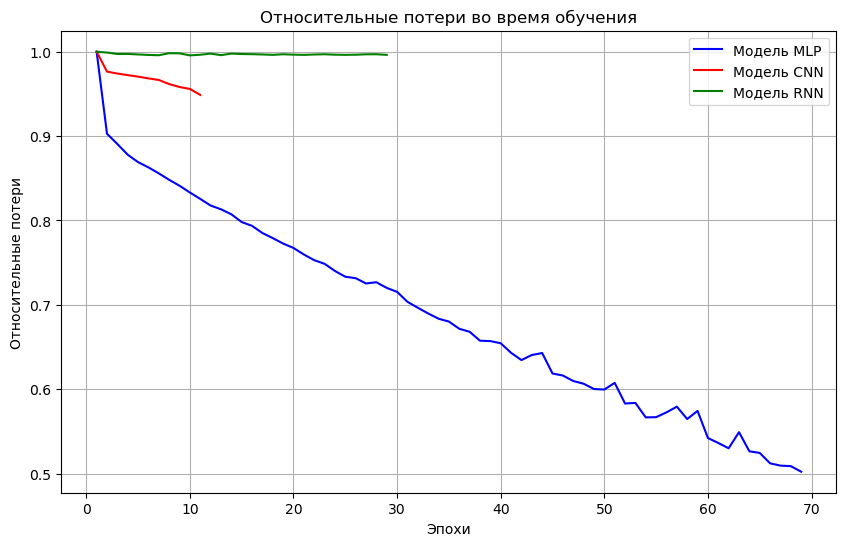

In [15]:
import matplotlib.pyplot as plt
import numpy as np

initial_loss_1 = history_1.history['loss'][0]
initial_loss_2 = history_2.history['loss'][0]
initial_loss_3 = history_3.history['loss'][0]

relative_losses_1 = np.array(history_1.history['loss']) / initial_loss_1
relative_losses_2 = np.array(history_2.history['loss']) / initial_loss_2
relative_losses_3 = np.array(history_3.history['loss']) / initial_loss_3

num_epochs = max(len(relative_losses_1), len(relative_losses_2), len(relative_losses_3))
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(relative_losses_1)], relative_losses_1, 'b-', label='Модель MLP')
plt.plot(epochs[:len(relative_losses_2)], relative_losses_2, 'r-', label='Модель CNN')
plt.plot(epochs[:len(relative_losses_3)], relative_losses_3, 'g-', label='Модель RNN')

plt.title('Относительные потери во время обучения')
plt.xlabel('Эпохи')
plt.ylabel('Относительные потери')
plt.legend()
plt.grid(True)
plt.show()

# 6. Визуализируйте кривые обучения трех построенных моделей для показателя доли верных ответов на валидационной выборке на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

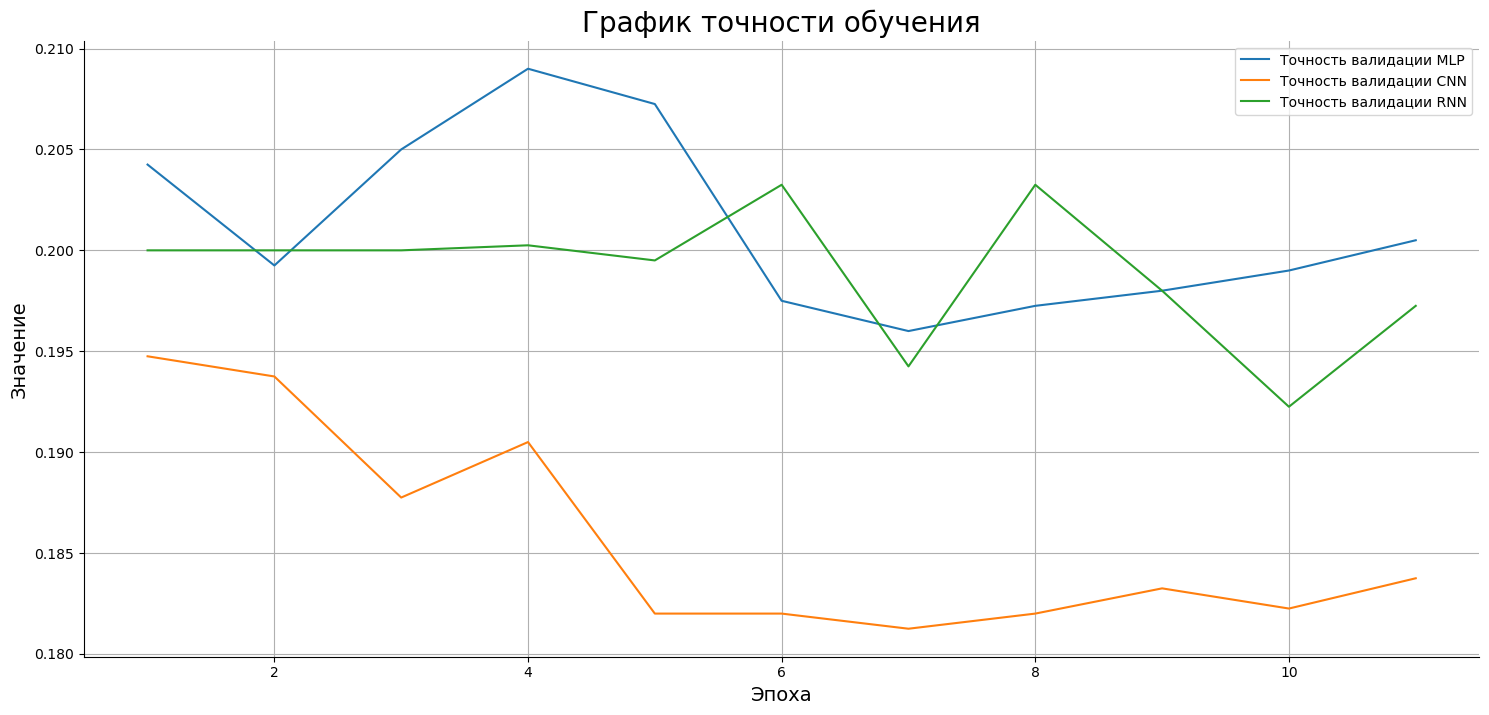

In [16]:
min_accuracy_length = min(len(history_1.history['accuracy']), len(history_2.history['accuracy']), len(history_3.history['accuracy']))
epochs = range(1, min_accuracy_length + 1)

plt.figure(figsize=(18, 8))
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.plot(epochs, history_1.history['val_accuracy'][:min_accuracy_length], label='Точность валидации MLP')
plt.plot(epochs, history_2.history['val_accuracy'][:min_accuracy_length], label='Точность валидации CNN')
plt.plot(epochs, history_3.history['val_accuracy'][:min_accuracy_length], label='Точность валидации RNN')

plt.title('График точности обучения', size=20)
plt.xlabel('Эпоха', size=14)
plt.ylabel('Значение', size=14)

plt.legend()
plt.grid(True)

plt.show()

# 7. Для каждого из классов определите два изображения в тестовой выборке, имеющее минимальную и максимальную вероятности классификации в правильный класс, и визуализируйте эти изображения.

16/16 [==============================] - 0s 3ms/step


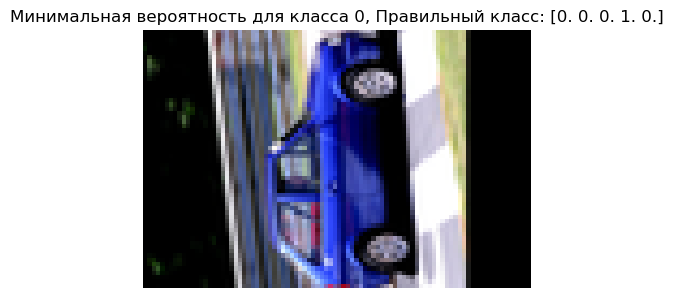

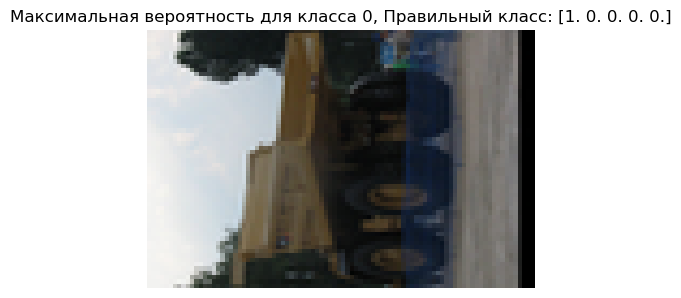

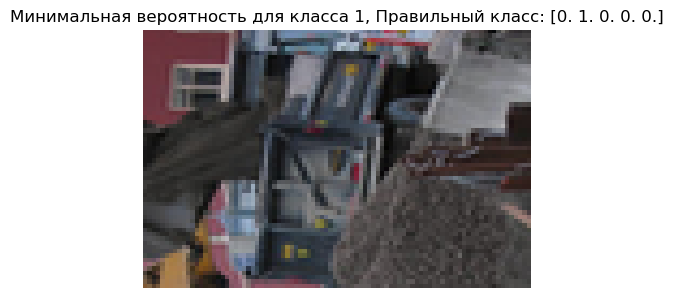

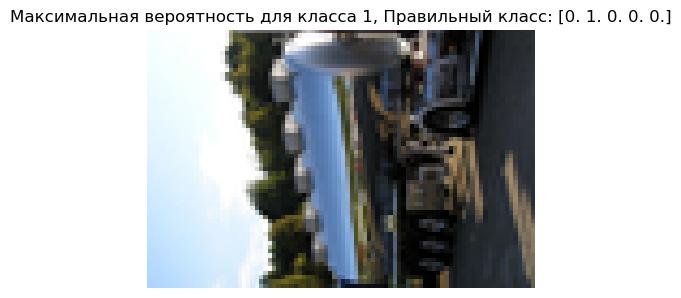

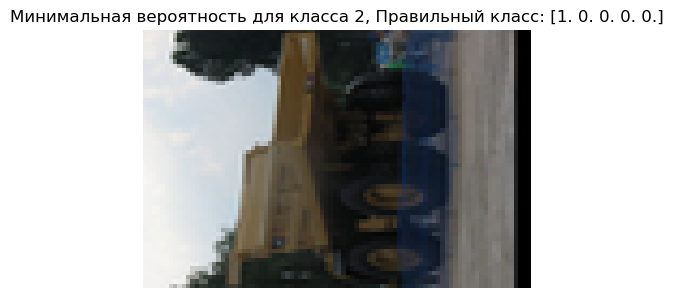

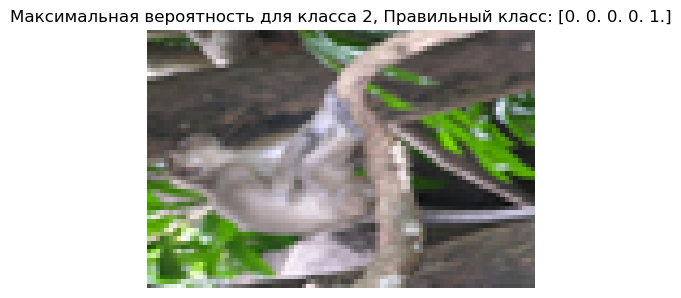

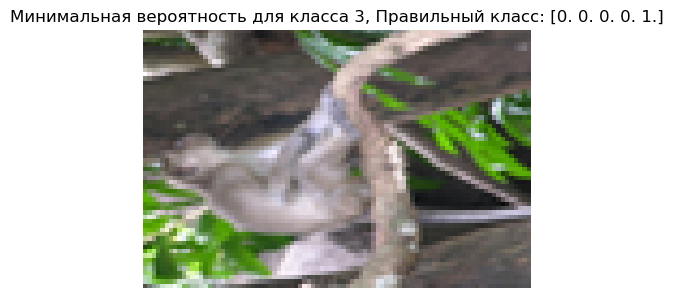

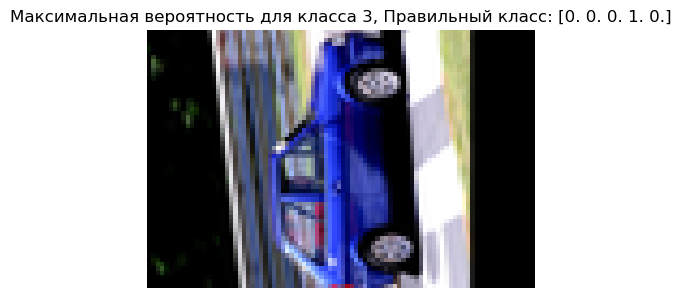

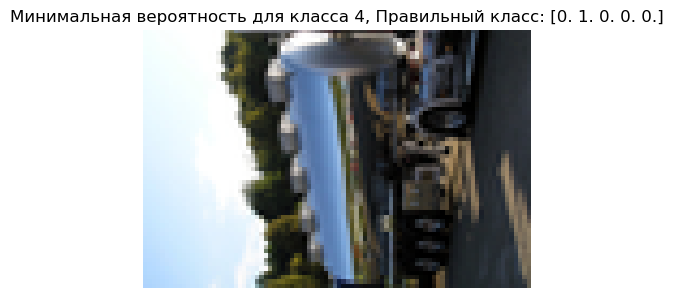

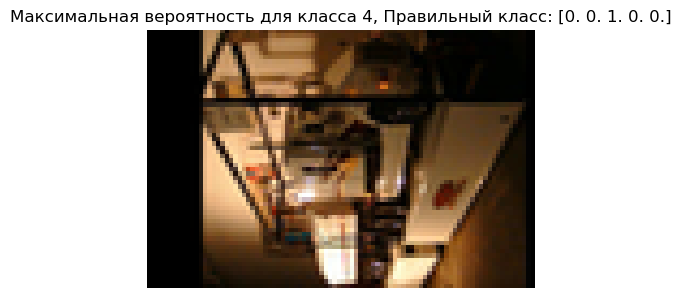

In [17]:
num_classes = len(values_to_keep)

probabilities = best_model.predict(test_images)

min_indices = np.argmin(probabilities, axis=1)
max_indices = np.argmax(probabilities, axis=1)

min_images = {}
max_images = {}

for i in range(len(test_images)):
    label = test_labels[i]
    min_index = min_indices[i]
    max_index = max_indices[i]
    if min_index not in min_images:
        min_images[min_index] = (test_images[i], label)
    if max_index not in max_images:
        max_images[max_index] = (test_images[i], label)

for class_index in range(num_classes):
    if class_index in min_images:
        min_image, min_label = min_images[class_index]
        
        plt.figure(figsize=(5, 5))
        plt.imshow(min_image)
        plt.title(f'Минимальная вероятность для класса {class_index}, Правильный класс: {min_label}')
        plt.axis('off')
        plt.show()

    if class_index in max_images:
        max_image, max_label = max_images[class_index]
        
        plt.figure(figsize=(5, 5))
        plt.imshow(max_image)
        plt.title(f'Максимальная вероятность для класса {class_index}, Правильный класс: {max_label}')
        plt.axis('off')
        plt.show()